# Preliminary Data Analysis

Some preliminary data analysis on the data acquired during regen testing on July 6th, between 22:02 and 22:04 (PST).
This notebook takes advantage of the custom `TimeSeries` class, which is a data-analysis centric wrapper around `np.ndarray`.

In [1]:
from influx_client import InfluxClient
from time_series import TimeSeries
import matplotlib.pyplot as plt
import numpy as np

# Setup
start = "2024-07-07T05:02:19Z"
stop = "2024-07-07T05:04:04Z"
client = InfluxClient()

Query the data, then align their x–axes such that math is well-defined.

In [2]:
pack_voltage: TimeSeries = client.query_time_series(start, stop, "TotalPackVoltage", units="V")
pack_current: TimeSeries = client.query_time_series(start, stop, "PackCurrent", units="A")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
pack_current, pack_voltage, vehicle_velocity = TimeSeries.align(pack_current, pack_voltage, vehicle_velocity)

Plot the data to make sure nothing bad or spooky happened (and matches what's seen on InfluxDB Data Explorer).

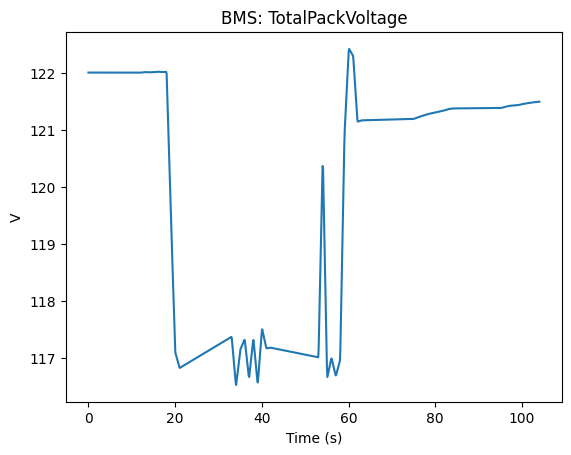

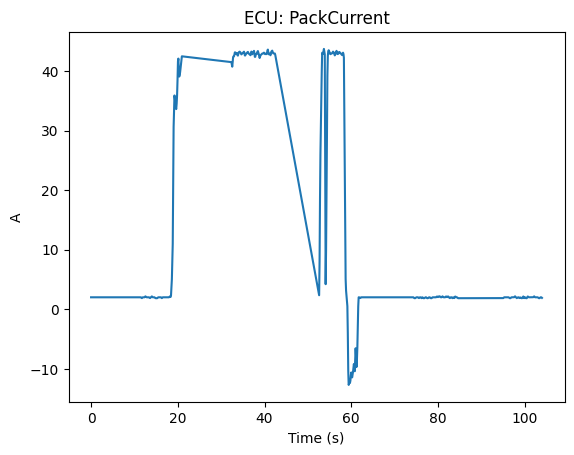

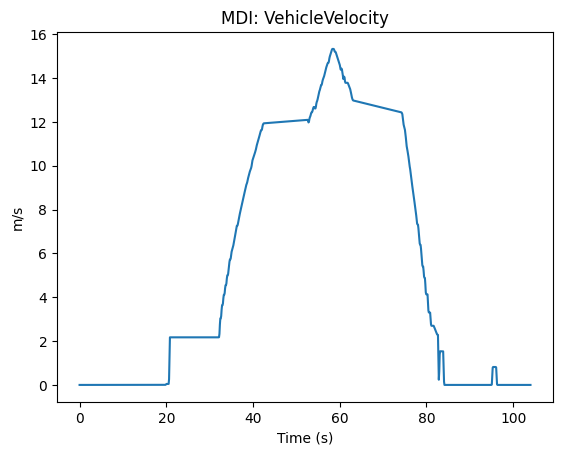

In [3]:
pack_voltage.plot(False)
pack_current.plot(False)
vehicle_velocity.plot(False)
plt.show()

Now, let's find the time that current is negative (regen is occurring).

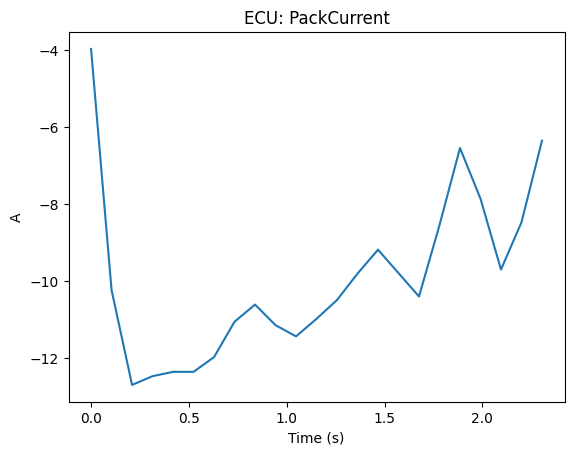

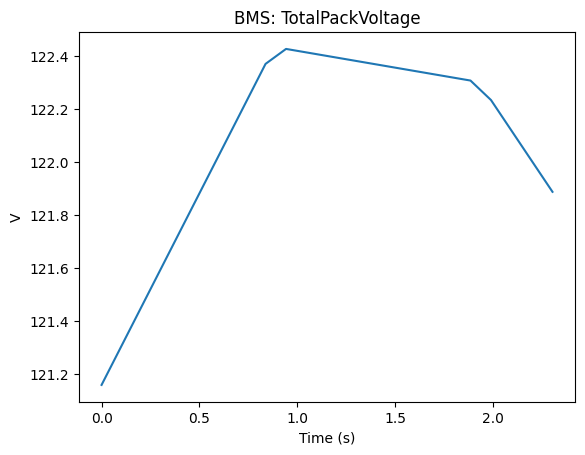

In [4]:
current_negative_mask = np.where(pack_current < 0)[0]

# We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
first_regen_index = current_negative_mask[0]
last_regen_index = current_negative_mask[-1]

regen_current = pack_current[first_regen_index:last_regen_index]
regen_voltage = pack_voltage[first_regen_index:last_regen_index]
regen_current.plot(False)
regen_voltage.plot(False)
plt.show()

We can also inspect the change in velocity to get a sense of the change in kinetic energy, estimating a vehicle mass of 300kg.

In [5]:
initial_velocity = vehicle_velocity[first_regen_index]                      # Units: m/s
final_velocity = vehicle_velocity[last_regen_index]                         # Units: m/s
mass: float = 300.                                                          # Units: kg
kinetic_energy  = lambda vi, vf: (1./2.) * 300 * (vf**2 - vi**2)            # Units: J
delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)    # Units: J

print(f"Initial Velocity: {initial_velocity:.4f} {vehicle_velocity.units}")
print(f"Final Velocity: {final_velocity:.4f} {vehicle_velocity.units}")
print(f"Change in Kinetic Energy: {delta_kinetic_energy:.4f} J")

Initial Velocity: 15.0949 m/s
Final Velocity: 13.7840 m/s
Change in Kinetic Energy: -5678.6500 J


Now, let's calculate the battery power during regen.
Note: the elementwise-array multiplication returns an `ndarray`, so I use `regen_current.promote()` on the result to get back a `TimeSeries`.

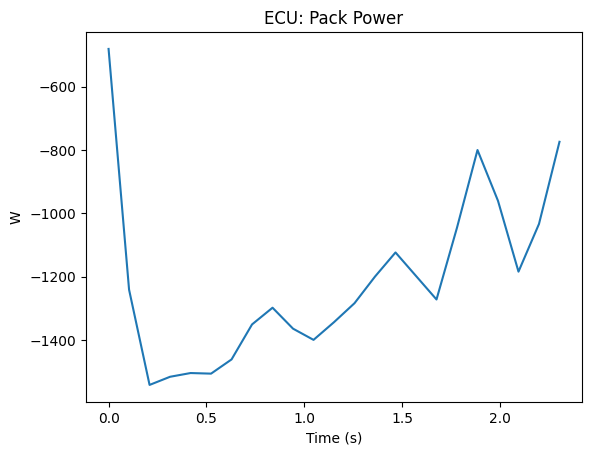

In [6]:
regen_power = regen_current.promote(regen_current * regen_voltage)
regen_power.units = "W"  # Fix units after math
regen_power.meta["field"] = "Pack Power"
regen_power.plot()

Now, let's integrate with respect to time to get regen energy, and then get efficiency.

In [7]:
regen_energy = np.trapz(regen_power, regen_power.x_axis)  # Units: J
efficiency: float = regen_energy / delta_kinetic_energy

print(f"Regen Energy: {regen_energy:.3f} J")
print(f"Regen Efficiency: {efficiency * 100:.6f}%")

Regen Energy: -2856.048 J
Regen Efficiency: 50.294495%
